In [1]:
#Loading some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpld3
import seaborn as sns
from scipy.interpolate import interp1d
%matplotlib inline
import scipy.stats
import os
user=os.getenv('USERNAME')
plt.style.use('ggplot')

# Analysis of power curves from Rnewables Ninja

In [2]:
# Loading dataframe containging technical data and power curve:
#  - power curve were donwloaded from the renewable ninja github (https://github.com/renewables-ninja)
#  - technical data come from thewindpower  (https://www.thewindpower.net/)
df = pd.read_pickle(r'C:\Users\romain\Desktop\Power_Curve_Project/dataframe.pkl')
#df = df.dropna()
df_TD = df.loc['technical_data']
df_TDt = df_TD.T

df_PCn = df.loc['power_curve']

df_TDt.head()

speed               ID        Name Manufucturer ID  Manufucturer Licence  \
Power curves name                                                          
Acciona.AW77.1500  180  AW-1500/77              46       Acciona     NaN   
Alstom.Eco.80      322          80              35  Alstom Power     NaN   
Alstom.Eco.110     325         110              35  Alstom Power     NaN   
Bonus.B23.150      194     B23/150              39         Bonus     NaN   
Bonus.B33.300      517     B33/300              39         Bonus     NaN   

speed              Wind class Wind class 2 Offshore Rated power  \
Power curves name                                                 
Acciona.AW77.1500     IEC IIa          NaN       No        1500   
Alstom.Eco.80         IEC IIa          NaN       No        1670   
Alstom.Eco.110     IEC IIa/Is          NaN       No        3000   
Bonus.B23.150             NaN          NaN       No         150   
Bonus.B33.300             NaN          NaN       No         300   

speed             Rotor diameter   ...    Generator manufacturer  \
Power curves name                  ...                             
Acciona.AW77.1500             77   ...                       NaN   
Alstom.Eco.80                 80   ...                       NaN   
Alstom.Eco.110             109.8   ...                       NaN   
Bonus.B23.150                 23   ...                       ABB   
Bonus.B33.300               33.4   ...                       ABB   

speed             Power regulation Tower manufacturer      Available since  \
Power curves name                                                            
Acciona.AW77.1500            Pitch  Acciona Windpower  2006-03-01 00:00:00   
Alstom.Eco.80                Pitch                NaN                  NaT   
Alstom.Eco.110               Pitch                NaN                  NaT   
Bonus.B23.150                Stall                NaN                  NaT   
Bonus.B33.300                Stall                NaN                  NaT   

speed                     Status               Update  Power curves name  \
Power curves name                                                          
Acciona.AW77.1500      Available  2017-08-30 00:00:00  Acciona.AW77.1500   
Alstom.Eco.80      Not available  2016-12-27 00:00:00      Alstom.Eco.80   
Alstom.Eco.110         Available  2016-12-27 00:00:00     Alstom.Eco.110   
Bonus.B23.150      Not available  2016-12-27 00:00:00      Bonus.B23.150   
Bonus.B33.300      Not available  2016-12-27 00:00:00      Bonus.B33.300   

speed                 HPWS     slope   WS 0.7  
Power curves name                              
Acciona.AW77.1500  8.53575  0.187731  9.60111  
Alstom.Eco.80      9.17828  0.168079  10.3682  
Alstom.Eco.110     8.30459  0.181809  9.40465  
Bonus.B23.150      8.73878  0.167016  9.93628  
Bonus.B33.300      8.53578  0.133047   10.039  

[5 rows x 46 columns]

In [3]:
# Loading of power curves from Renewable.Ninja
df_pc = pd.read_csv(r'C:\Users\romain\Desktop\Power_Curve_Project/power_curves.txt', header = 0, index_col = 0)
df_pc1 = pd.read_csv(r'C:\Users\romain\Desktop\Power_Curve_Project/power_curves_01.txt', header = 0, index_col = 0)
df_pc2 = pd.read_csv(r'C:\Users\romain\Desktop\Power_Curve_Project/power_curves_02.txt', header = 0, index_col = 0)
df_pc3 = pd.read_csv(r'C:\Users\romain\Desktop\Power_Curve_Project/power_curves_03.txt', header = 0, index_col = 0)
df_pc4 = pd.read_csv(r'C:\Users\romain\Desktop\Power_Curve_Project/power_curves_04.txt', header = 0, index_col = 0)

df_PCj = pd.concat([df_pc, df_pc1, df_pc2, df_pc3, df_pc4], axis = 1, keys = ['pc', 'pc1', 'pc2', 'pc3', 'pc4'])
df_PCj = df_PCj.swaplevel(axis = 1)

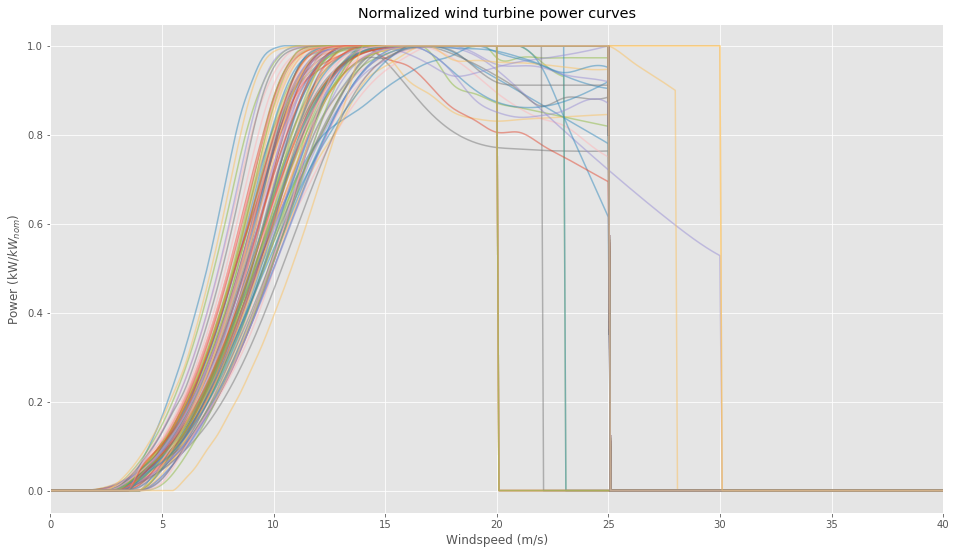

In [4]:
#Observation of normalized power curve
fig, ax = plt.subplots(figsize = (16,9))
df_PCn.iloc[::10, :].plot(ax =ax, alpha = 0.5, legend = False,)
plt.title('Normalized wind turbine power curves')
plt.ylabel('Power (kW/$kW_{nom}$)')
plt.xlabel('Windspeed (m/s)')

Some turbines reach their nominal power at lower wind speed than others.

As demonstrated below, it is determined by their rotor size.

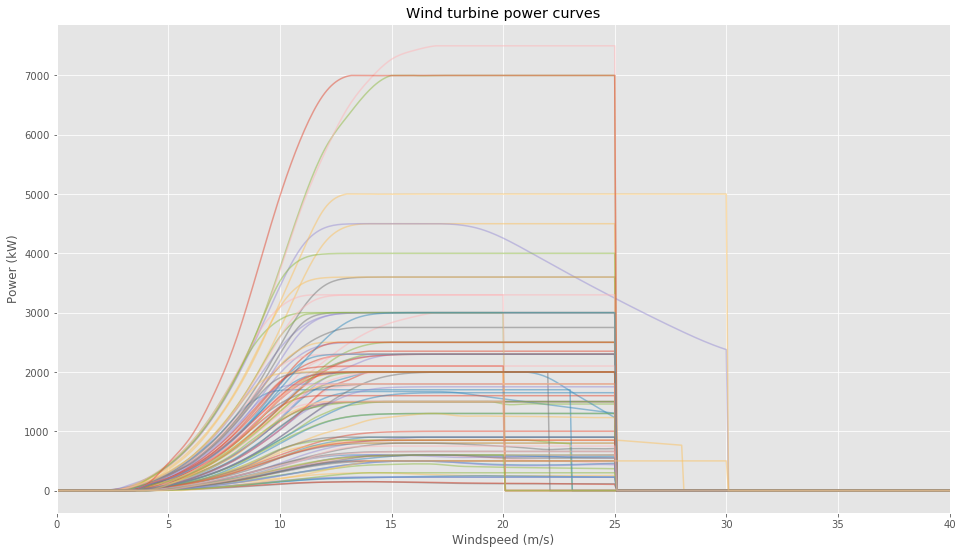

In [5]:
#Observation of power curves in absolute power
df_PC = df_PCn * df_TDt['Rated power']
fig, ax = plt.subplots(figsize = (16,9))
df_PC.iloc[::10, :].plot(ax =ax, alpha = 0.5, legend = False,)
plt.title('Wind turbine power curves')
plt.ylabel('Power (kW)')
plt.xlabel('Windspeed (m/s)')

Production increase with the cubic windspeed before saturating to their nominal power.

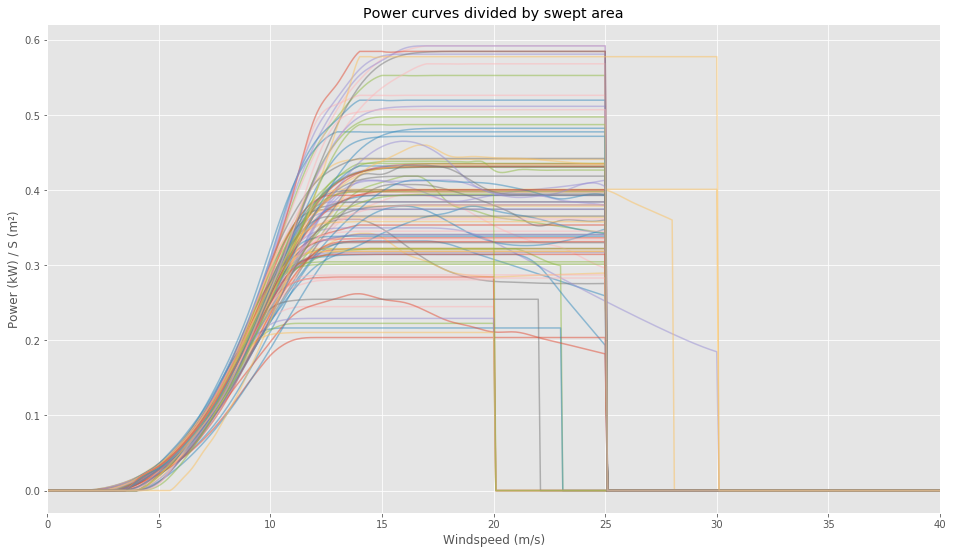

In [6]:
#Observation of power curve normalized by swept area
df_PCs = df_PC / df_TDt['Swept area']

fig, ax = plt.subplots(figsize = (16,9))
df_PCs.iloc[::10, :].plot(ax =ax, alpha = 0.5, legend =False)
plt.title('Power curves divided by swept area')
plt.ylabel('Power (kW) / S (m²)')
plt.xlabel('Windspeed (m/s)')

When normalised by swept area, power curves become similar.

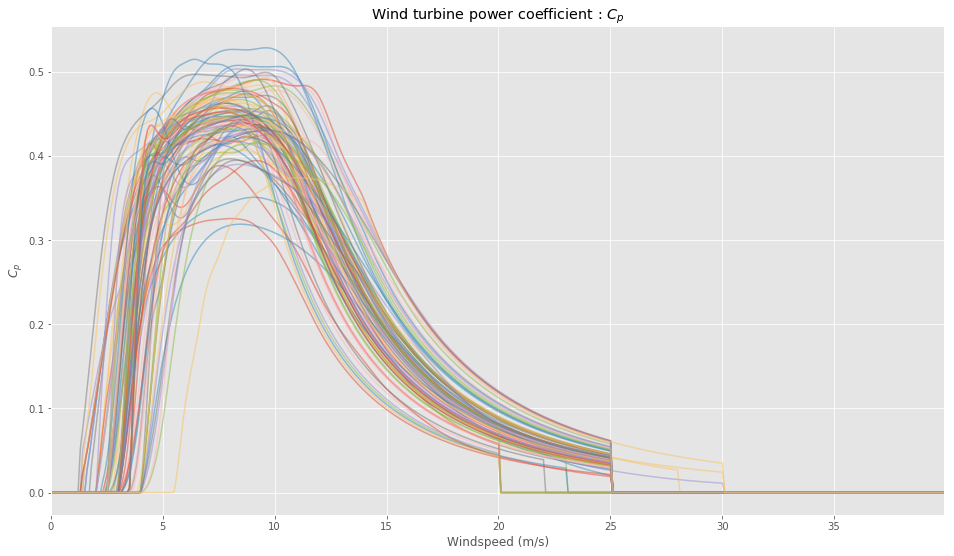

In [7]:
#Observation of wind power coefficient (Cp) as a function of wind speed
rho = 1.225
df_Cp = (2*df_PCs[1:]*1e3).div(rho *  df_PCs[1:].index.values**3, axis = 0)

fig, ax = plt.subplots(figsize = (16,9))
df_Cp.iloc[::10, :].plot(ax = ax, alpha = 0.5, legend = False)
plt.title('Wind turbine power coefficient : $C_p$')
plt.ylabel('$C_p$')
plt.xlabel('Windspeed (m/s)')

The Cp reach its maximum after the cut-in wind speed and decreased at windspeed for which the production saturate.

count    98.000000
mean      0.447065
std       0.035626
min       0.318939
25%       0.432416
50%       0.447467
75%       0.466019
max       0.528515
dtype: float64

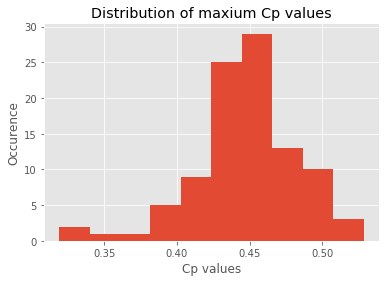

In [8]:
#Observation of the distribution of maximum Cp value
fig, ax = plt.subplots()
plt.title('Distribution of maxium Cp values')
plt.ylabel('Occurence')
plt.xlabel('Cp values')
display(df_Cp.max().describe())
df_Cp.max().hist()

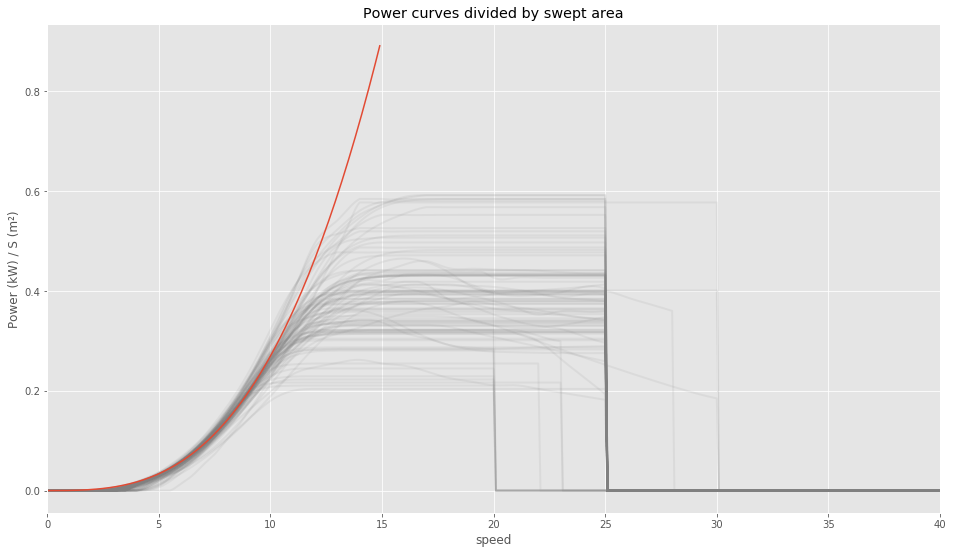

In [9]:
#Observation of power curves normalized by swept area and compared to median Cp value of 0.44
df_PCs = df_PC / df_TDt['Swept area']

fig, ax = plt.subplots(figsize = (16,9))
df_PCs.iloc[::10, :].plot(ax =ax, alpha = 0.1, color = 'grey', lw = 2, legend = False)
plt.title('Power curves')
plt.title('Power curves divided by swept area')
plt.ylabel('Power (kW) / S (m²)')

v = np.arange(0, 15, 0.1)
plt.plot(v, 1/2*1.225*0.44*v**3/1e3)

Power curves are correctly modelled untill the production saturate.

The power will be limited to the nominal power of the wind turbine and smooth by a gaussian filter with a width corresponding the turbulence intensity.

# Power Curve Generator

In [10]:
# Model to generate power curve from nominale power and rotor dimension

#Fonction générant la power curve
def PowerCurveGenerator(P, d, TI = 0.10, cut_in = 3.5, cut_out = 25, Cp = 0.44, normalized = False):
    """
    This function generate wind turbine power curve from nominal power and rotor dimension and turbulence intensity used to smooth the power curve (10% by default).
    List of parameters : P (rated power) expressed in kW, d (rotor diameter) expressed in m.
    Cut-in wind speed and cut-out wind speed can be adjusted, by default values are 3.5 m/s and 25 m/s. 
    Cp value is set at 0.44 corresponding to the mean value of a set of wind turbine model. 
    """
    #Convertion from kW to W
    P = P*1e3
    
    #Physical parameters
    rho = 1.225 #kg/m3, air density, could be calculated based on temperature and altitude
    S = np.pi * (d/2)**2 #m², rotor area
    
    #Calculation parameters
    a = 5 #m/s, Truncature width of the Gaussian filter for turbulence intensity
    speed_step = 0.1 #Step for wind power curve
    
    #Power calculation (P proportional to wind_speed^3)
    df_bpc = pd.DataFrame(index = np.arange(0, 40 + speed_step, speed_step), columns = ['wind_speed'])
    df_bpc['wind_speed'] = df_bpc.index
    df_bpc['P'] = 1/2 * rho * S * Cp * df_bpc.wind_speed**3 
    #Saturation of the power output to the nominal value
    df_bpc['P'][ df_bpc['P'] >  P ] = P  
    #Gaussian filter over w*(1-TI):w*(1+TI), TI being the turbulence intensity
    df_bpc['P_with_TI'] = np.nan
    df_bpc.iloc[ ::int(1/speed_step), df_bpc.columns.get_loc('P_with_TI')] = [ df_bpc['P'].rolling(window = int(a*TI*w/speed_step), win_type='gaussian', center = True).mean(std = int(TI*w/speed_step)).loc[w] for w in np.arange(0,41)]
    df_bpc['P_with_TI'].interpolate(method='cubic', inplace = True)
    df_bpc['P_with_TI'][df_bpc['P_with_TI'] < 0] = 0
    df_bpc['P_with_TI'][df_bpc['wind_speed'] < (1-2*TI)*cut_in] = 0

    #Cut-in wind speed and cutout wind speed
    df_bpc['P'][ df_bpc['wind_speed'] < cut_in] = 0
    df_bpc['P'][ df_bpc['wind_speed'] > cut_out] = 0
    df_bpc['P_with_TI'][ df_bpc['wind_speed'] > cut_out] = 0
    
    
    del df_bpc['wind_speed']
    df_bpc['P'] = df_bpc['P']/1e3
    df_bpc['P_with_TI'] = df_bpc['P_with_TI']/1e3
    df_bpc = df_bpc.replace(np.nan, 0)
    df_bpc.index.name = 'wind speed'
    
    if normalized:
        df_bpc = df_bpc/(P*1e-3)
             
    return df_bpc

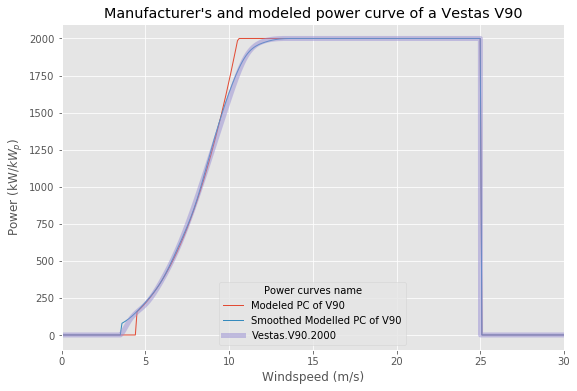

In [11]:
fig, ax = plt.subplots(figsize=(9, 6))
df_bpc = PowerCurveGenerator(2000, 90, normalized= False, cut_in = 4.5)
df_bpc.columns = [['Modeled PC of V90', 'Smoothed Modelled PC of V90']]
df_bpc.plot(ax = ax, alpha = 2, lw = 1)
df_PC[['Vestas.V90.2000']].plot(ax = ax, lw = 5, alpha = 0.5)

#df_pc[['Bonus.B23.150']].plot(ax = ax)
plt.xlim([0, 30])
plt.xlabel('Windspeed (m/s)')
plt.ylabel('Power (kW/$kW_p$)')
plt.title('Manufacturer\'s and modeled power curve of a Vestas V90')

# Validation of the model with data from la haute borne ENGIE wind farm

In [12]:
#Loading the ENGIE data (https://opendata-renewables.engie.com/explore/dataset/la-haute-borne-data-2013-2016/table/)
name = 'ENGIE'
df_SARAH = pd.read_pickle(r'C:\Users\romain\Desktop\Power_Curve_Project\NinjaData_%s_SarahSolar.pkl'%name)
df_WIND = pd.read_pickle(r'C:\Users\romain\Desktop\Power_Curve_Project\NinjaData_%s_MerraWind.pkl'%name)
df_engie = pd.read_pickle(r'C:\Users\romain\Desktop\Power_Curve_Project\la-haute-borne-data-2013-2016.pkl')

In [13]:
# Selection des variables d'intérêt et calcul de l'intensité de turbulence
df_NG = df_engie[['P_avg', 'Ws_avg','Ws_std']]
df_NG['TI'] = df_NG.Ws_std/df_NG.Ws_avg

C:\Users\romain\Miniconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0, 15)

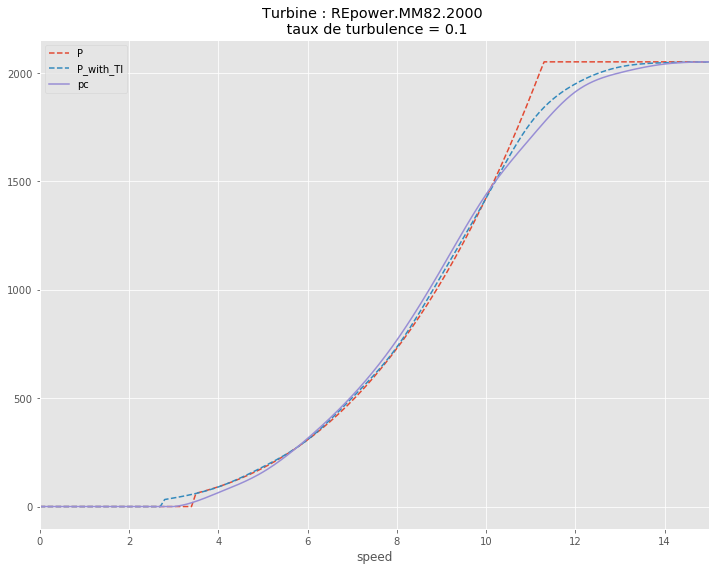

In [14]:
# Application sur la turbine REpower MM82 2000
turbine = 'REpower.MM82.2000'
TI = 0.10
df_bpc5 = PowerCurveGenerator(P = 2050, d = 82, TI = TI)

fig, ax = plt.subplots(figsize = (12,9))
df_bpc5.plot(ax = ax, ls = '--')
(df_PCj['REpower.MM82.2000']['pc'].iloc[::5]*2050).plot(ax = ax)
plt.title('Turbine : %s \n taux de turbulence = %s' %(turbine, TI))
plt.legend()
plt.xlim([0,15])

#mpld3.display(fig)

In [15]:
df_pc_TI = pd.DataFrame()
df_bpc5 = PowerCurveGenerator(P = 2050, d = 82, TI = 0.05)
df_pc_TI['5%'] = df_bpc5.P_with_TI
df_bpc5 = PowerCurveGenerator(P = 2050, d = 82, TI = 0.10)
df_pc_TI['10%'] = df_bpc5.P_with_TI
df_bpc5 = PowerCurveGenerator(P = 2050, d = 82, TI = 0.15)
df_pc_TI['15%'] = df_bpc5.P_with_TI
df_bpc5 = PowerCurveGenerator(P = 2050, d = 82, TI = 0.20)
df_pc_TI['20%'] = df_bpc5.P_with_TI

C:\Users\romain\Miniconda3\envs\python36\lib\site-packages\scipy\signal\windows.py:1217: RuntimeWarning: divide by zero encountered in true_divide
  w = np.exp(-n ** 2 / sig2)


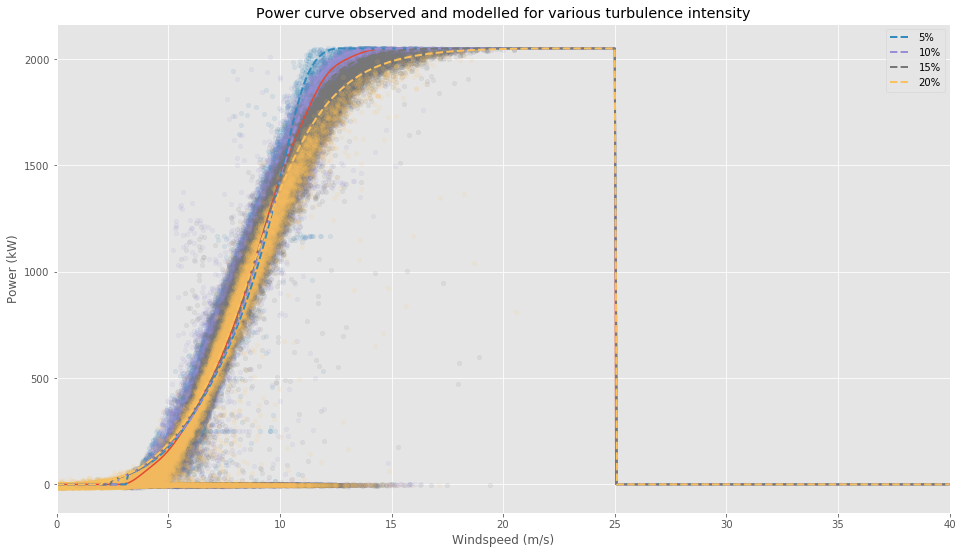

In [17]:
fig, ax = plt.subplots(figsize = (16,9))
#color = sns.light_palette("green", 8)
color = sns.color_palette()
df_NG[df_NG.TI < 0.05].plot(kind = 'scatter', x = 'Ws_avg', y = 'P_avg', ax = ax, alpha = 0.1, color = color[0])
df_NG[(df_NG.TI >= 0.05)&(df_NG.TI < 0.1)].plot(kind = 'scatter', x = 'Ws_avg', y = 'P_avg', ax = ax, alpha = 0.1, color = color[1])
df_NG[(df_NG.TI >= 0.10)&(df_NG.TI < 0.15)].plot(kind = 'scatter', x = 'Ws_avg', y = 'P_avg', ax = ax, alpha = 0.1, color = color[2])
df_NG[(df_NG.TI >= 0.15)&(df_NG.TI < 0.2)].plot(kind = 'scatter', x = 'Ws_avg', y = 'P_avg', ax = ax, alpha = 0.1, color = color[3])
df_NG[(df_NG.TI >= 0.20)].plot(kind = 'scatter', x = 'Ws_avg', y = 'P_avg', ax = ax, alpha = 0.1, color = color[4])
(df_PCj['REpower.MM82.2000'].pc.iloc[::5]*2050).plot(ax = ax)
df_pc_TI.plot(ax = ax, alpha = 2, lw = 2, ls = '--')
plt.title('Power curve observed and modelled for various turbulence intensity')
plt.ylabel('Power (kW)')
plt.xlabel('Windspeed (m/s)')

The higher the turbulence is, the smoother the power curves are. 
It justifies the width of the gaussian filter proportional to the wind speed.

Vestas


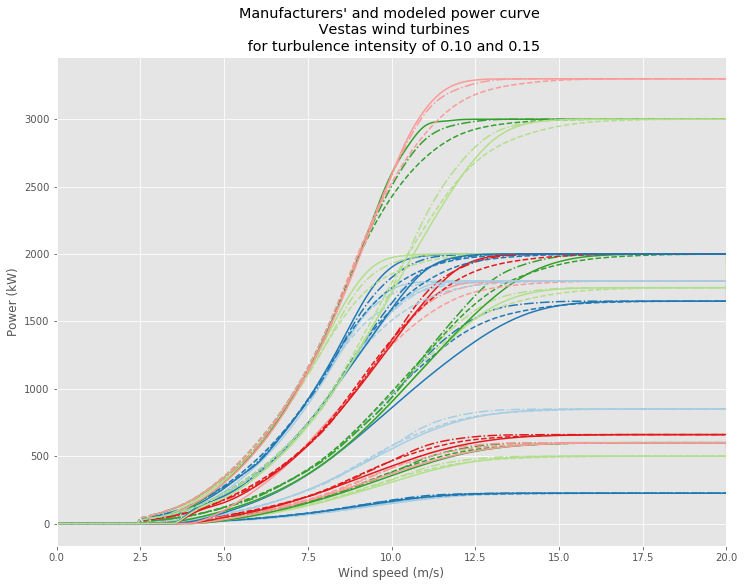

In [18]:
# Observation of the ability of the modele for different wind turbines
# avec TI = 0.10
df_PC = df_PCn * df_TDt['Rated power']

#for manufacturer in set(df_TDt.Manufucturer):
for manufacturer in ['Vestas']:

    list_WT = [wt for wt in df_PC.columns if manufacturer in str(wt) and '' in str(wt)]

    TI = 0.10

    color = sns.color_palette("Paired")
    fig, ax = plt.subplots(figsize = (12,9))

    for i, wt in enumerate(list_WT):
        if wt!= 'Vestas.V164.7000':
            
            P = df_TDt.loc[wt]['Rated power']
            d = df_TDt.loc[wt]['Rotor diameter']
            df_PC.iloc[::10,:][wt].plot(ax =ax, color = color[i%6])
            df_bpc = PowerCurveGenerator(P = P, d = d, TI = TI)
            df_bpc_p = df_bpc[['P_with_TI']]
            df_bpc_p.columns = ['Model TI=0.10 %s'%wt]
            df_bpc_p.plot(ax = ax, ls = '-.', color = color[i%6], legend = False)

            df_bpc = PowerCurveGenerator(P = P, d = d, TI = 0.15)
            df_bpc_p = df_bpc[['P_with_TI']]
            df_bpc_p.columns = ['Model TI=0.15 %s'%wt]
            df_bpc_p.plot(ax = ax, ls = '--', color = color[i%6], legend = False)
    
    print(manufacturer)

    plt.title('Manufacturers\' and modeled power curve \n %s wind turbines\n for turbulence intensity of 0.10 and 0.15'%manufacturer)
    plt.ylabel('Power (kW)')
    plt.xlabel('Wind speed (m/s)')

    #plt.legend(bbox_to_anchor=(1.2, 0.2))
    plt.xlim([0,20])


# Estimation of the annual production for la haute borne windspeed data 

In [30]:
#Adding the MM82 2MW turbine to the dataframe
df_TD = df_TDt.T
df_TD['REpower.MM82.2000'] = np.nan
df_TD['REpower.MM82.2000'].loc['Rated power'] = 2050
df_TD['REpower.MM82.2000'].loc['Rotor diameter'] = 82
df_TD['REpower.MM82.2000'].loc['Swept area'] = np.pi * (df_TD['REpower.MM82.2000'].loc['Rotor diameter']/2)**2
df_TDt = df_TD.T
df_PCn = df.loc['power_curve']
df_PCn['REpower.MM82.2000'] = df_PCj['REpower.MM82.2000'].pc

df_PC = df_PCn * df_TDt['Rated power']

C:\Users\romain\Miniconda3\envs\python36\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [31]:
#Récupération des données moyenne sur les 4  turbines ou une seule
#df_NG2 = df_NG.resample('h').mean()
df_NG2 = df_NG.resample('h').first()
df_NG2.head()

P_avg    Ws_avg  Ws_std        TI
Date_time                                                  
2012-12-31 23:00:00   679.69000  7.250000    1.01  0.139310
2013-01-01 00:00:00  1303.77000  9.479999    1.10  0.116034
2013-01-01 01:00:00  1034.47000  8.600000    1.18  0.137209
2013-01-01 02:00:00   844.01001  7.930000    1.06  0.133670
2013-01-01 03:00:00  1272.03000  9.400000    1.47  0.156383

In [32]:
#Average turbulence intensity
df_NG.replace(np.inf, np.nan).resample('h').first().resample('a').mean()

P_avg    Ws_avg    Ws_std        TI
Date_time                                           
2012-12-31  679.690000  7.250000  1.010000  0.139310
2013-12-31  279.348380  5.387539  0.744483  0.213494
2014-12-31  321.006279  5.286354  0.720479  0.222844
2015-12-31  385.267883  5.610176  0.771134  0.213261
2016-12-31  334.727520  5.316847  0.731994  0.226536

A turbulence intensity of 20% will be used.

In [33]:
#Manufacturer power curves
df_PCc = df_PC[0:-1:10]
df_PCc = pd.concat([df_PCc, df_PC[-1:]])
df_PCc = df_PCc.astype(float)

In [24]:
#Modeled power curves
df_PCm = pd.DataFrame(index = df_PCc.index, columns = df_PCc.columns)

for turbine in df_TDt.index:
    #print(turbine)
    pc = PowerCurveGenerator(df_TDt.loc[turbine]['Rated power'], df_TDt.loc[turbine]['Rotor diameter'], TI = 0.20, cut_in = 3.5, cut_out = 25)
    df_PCm[turbine] = pc.P_with_TI.values
    
df_PCm   

Power curves name  Acciona.AW77.1500  Alstom.Eco.80  Alstom.Eco.110  \
speed                                                                 
0.0                         0.000000       0.000000        0.000000   
0.1                         0.000000       0.000000        0.000000   
0.2                         0.000000       0.000000        0.000000   
0.3                         0.000000       0.000000        0.000000   
0.4                         0.000000       0.000000        0.000000   
0.5                         0.000000       0.000000        0.000000   
0.6                         0.000000       0.000000        0.000000   
0.7                         0.000000       0.000000        0.000000   
0.8                         0.000000       0.000000        0.000000   
0.9                         0.000000       0.000000        0.000000   
1.0                         0.000000       0.000000        0.000000   
1.1                         0.000000       0.000000        0.000000   
1.2                         0.000000       0.000000        0.000000   
1.3                         0.000000       0.000000        0.000000   
1.4                         0.000000       0.000000        0.000000   
1.5                         0.000000       0.000000        0.000000   
1.6                         0.000000       0.000000        0.000000   
1.7                         0.000000       0.000000        0.000000   
1.8                         0.000000       0.000000        0.000000   
1.9                         0.000000       0.000000        0.000000   
2.0                         0.000000       0.000000        0.000000   
2.1                        12.053275      13.010650       24.509326   
2.2                        13.901374      15.005433       28.267418   
2.3                        15.929336      17.194383       32.391221   
2.4                        18.145511      19.586523       36.897705   
2.5                        20.558249      22.190875       41.803840   
2.6                        23.175902      25.016462       47.126597   
2.7                        26.006820      28.072306       52.882944   
2.8                        29.059355      31.367430       59.089852   
2.9                        32.341856      34.910856       65.764291   
...                              ...            ...             ...   
37.1                        0.000000       0.000000        0.000000   
37.2                        0.000000       0.000000        0.000000   
37.3                        0.000000       0.000000        0.000000   
37.4                        0.000000       0.000000        0.000000   
37.5                        0.000000       0.000000        0.000000   
37.6                        0.000000       0.000000        0.000000   
37.7                        0.000000       0.000000        0.000000   
37.8                        0.000000       0.000000        0.000000   
37.9                        0.000000       0.000000        0.000000   
38.0                        0.000000       0.000000        0.000000   
38.1                        0.000000       0.000000        0.000000   
38.2                        0.000000       0.000000        0.000000   
38.3                        0.000000       0.000000        0.000000   
38.4                        0.000000       0.000000        0.000000   
38.5                        0.000000       0.000000        0.000000   
38.6                        0.000000       0.000000        0.000000   
38.7                        0.000000       0.000000        0.000000   
38.8                        0.000000       0.000000        0.000000   
38.9                        0.000000       0.000000        0.000000   
39.0                        0.000000       0.000000        0.000000   
39.1                        0.000000       0.000000        0.000000   
39.2                        0.000000       0.000000        0.000000   
39.3                        0.000000       0.000000        0.000000   
39.4                    

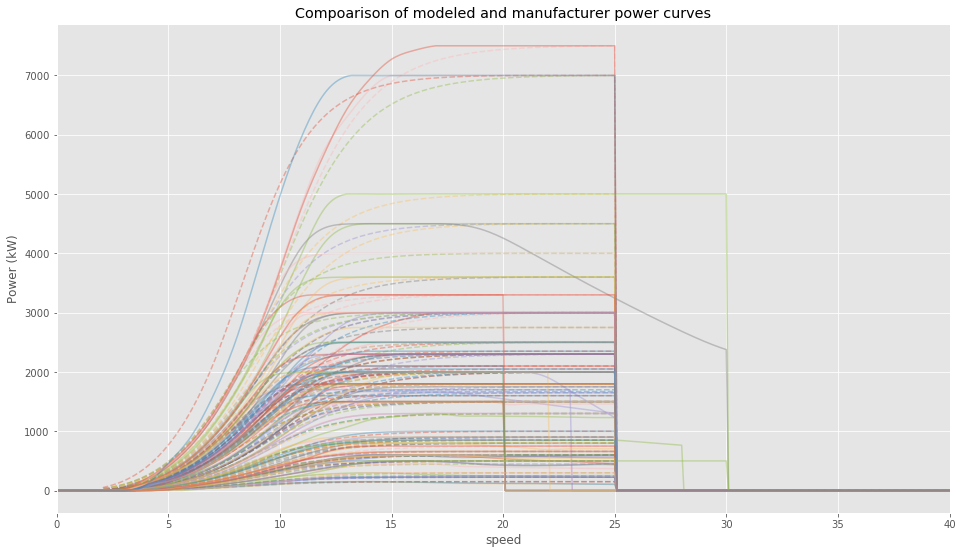

In [25]:
fig, ax = plt.subplots( figsize= (16,9))
df_PCm.plot(ax = ax, ls ='--', alpha = 0.4, legend = False )
df_PCc.plot(ax = ax, alpha = 0.4, legend = False)
plt.title('Compoarison of modeled and manufacturer power curves')
plt.ylabel('Power (kW)')

In [26]:
#Estimation of annual production from manuafturer and modeled power curves 
df_Pc = pd.DataFrame(index = df_NG2.index)
df_Pm = pd.DataFrame(index = df_NG2.index)

for turbine in df_TDt.index:
    #print(turbine)
    df_Pc[turbine] = np.interp(df_NG2.Ws_avg.values, df_PCc.index.values, df_PCc[turbine].values)
    df_Pm[turbine] = np.interp(df_NG2.Ws_avg.values, df_PCc.index.values, df_PCm[turbine].values)
    
df_P = pd.concat([df_Pc, df_Pm], axis = 1, keys = ['Manufacturer','Modeled'])

In [27]:
# Production from manufacturer or modeled power curve as well as measured production.
df_HB = pd.concat([df_NG2['P_avg'], df_P.swaplevel(axis = 1)['REpower.MM82.2000'] ], axis = 1)
df_HB = df_HB['2013':]
df_HB['P measured'] = df_HB.P_avg
del df_HB['P_avg']
df_HB.head()

Manufacturer      Modeled  P measured
Date_time                                                 
2013-01-01 00:00:00   1266.704477  1236.721081  1303.77000
2013-01-01 01:00:00    957.484690   971.755074  1034.47000
2013-01-01 02:00:00    746.662044   772.340740   844.01001
2013-01-01 03:00:00   1238.536445  1213.423737  1272.03000
2013-01-01 04:00:00   1530.263713  1462.165596  1509.38000

In [28]:
fig, ax = plt.subplots(figsize = (9, 6))
df_HB['2015-01'][['P measured']].plot(ax = ax, alpha = 1)
df_HB['2015-01'][['Manufacturer','Modeled']].plot(ax = ax, alpha = 0.5)
mpld3.display(fig)

In [36]:
#Calcul of mean absolute error
df_HB['MAE Manufacturer'] = df_HB['P measured'] - df_HB['Manufacturer']
df_HB['MAE Manufacturer'] = df_HB['MAE Manufacturer'].abs()

df_HB['MAE Modeled'] = df_HB['P measured'] - df_HB['Modeled']
df_HB['MAE Modeled'] = df_HB['MAE Modeled'].abs()

In [34]:
df_HB[['MAE Manufacturer','MAE Modeled']].resample('a').mean()

MAE Manufacturer  MAE Modeled
Date_time                                
2013-12-31         98.754147   110.624866
2014-12-31         40.962343    51.025515
2015-12-31         52.892383    60.701581
2016-12-31         48.229689    57.268468

In [35]:
PA = df_HB[['P measured', 'Manufacturer', 'Modeled']].resample('a').mean() / 2050
PA

P measured  Manufacturer   Modeled
Date_time                                     
2013-12-31    0.136268      0.168602  0.177357
2014-12-31    0.156588      0.158646  0.167690
2015-12-31    0.187936      0.188845  0.196111
2016-12-31    0.163282      0.164943  0.173072

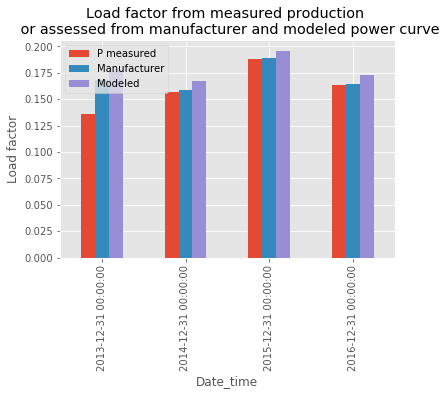

In [38]:
PA.plot(kind = 'bar')
plt.title('Load factor from measured production \n or assessed from manufacturer and modeled power curve')
plt.ylabel('Load factor')

In [70]:
PA.divide(PA['P measured'], axis = 0)

P measured  Manufacturer   Modeled
Date_time                                     
2013-12-31         1.0      1.237284  1.301534
2014-12-31         1.0      1.013138  1.070899
2015-12-31         1.0      1.004842  1.043502
2016-12-31         1.0      1.010174  1.059961

C:\Users\romain\Miniconda3\envs\python36\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


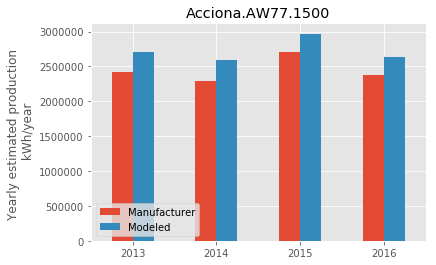

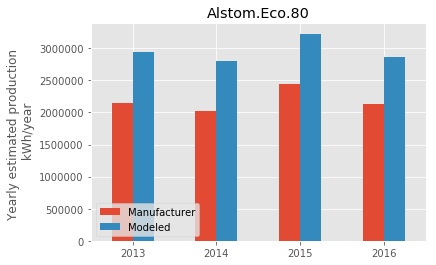

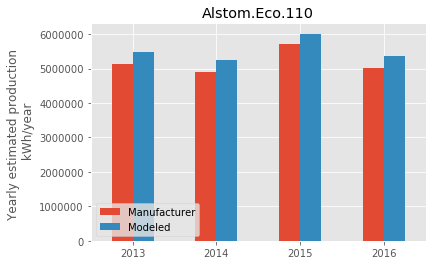

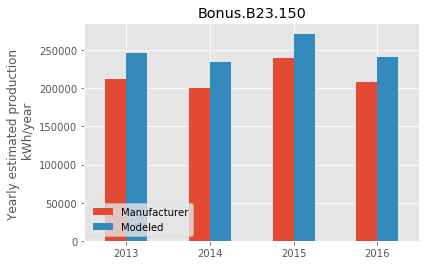

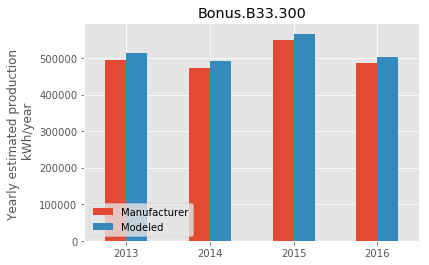

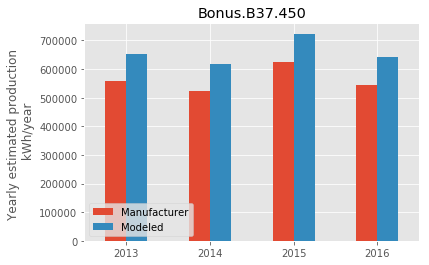

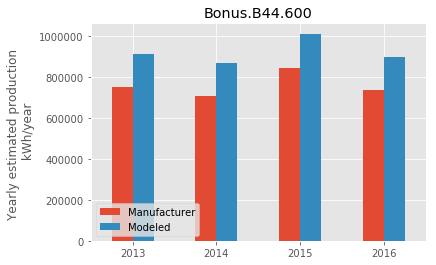

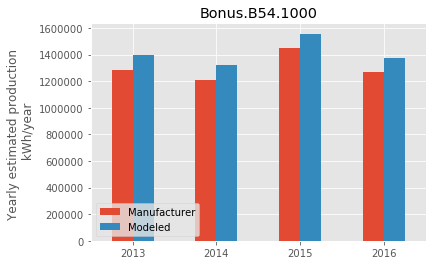

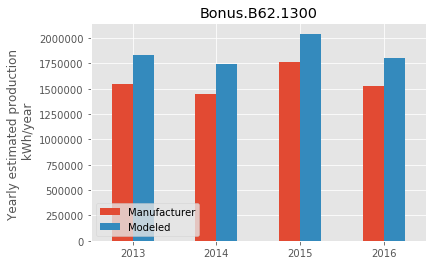

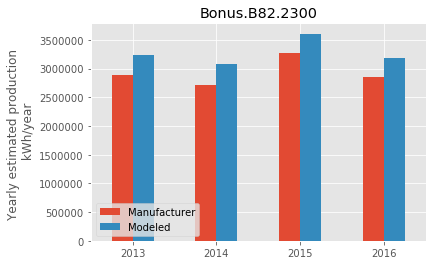

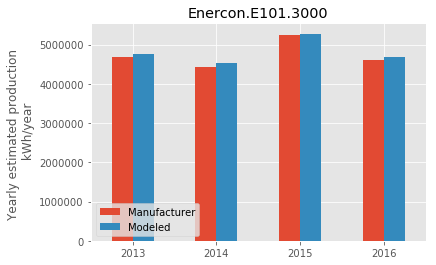

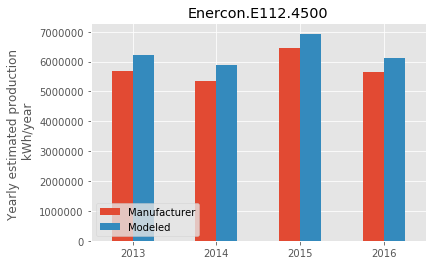

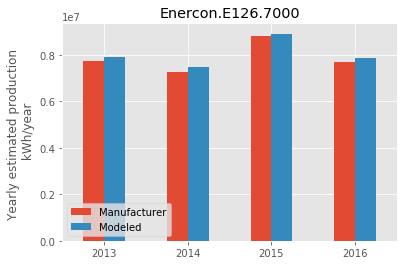

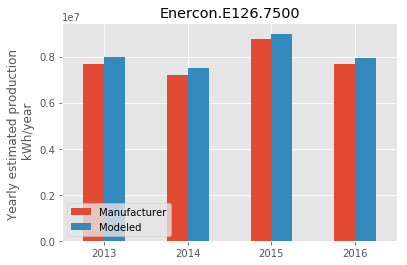

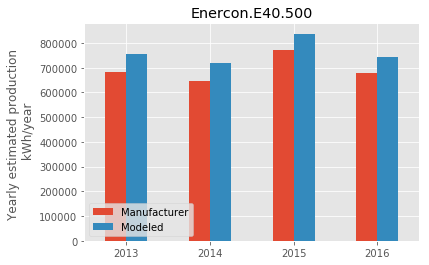

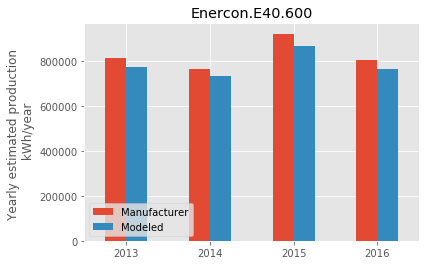

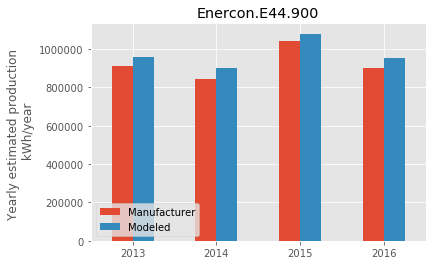

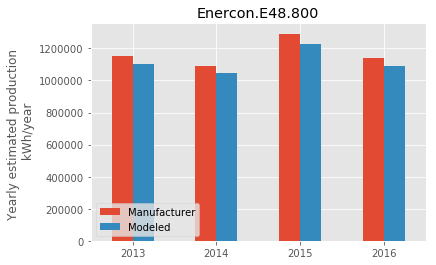

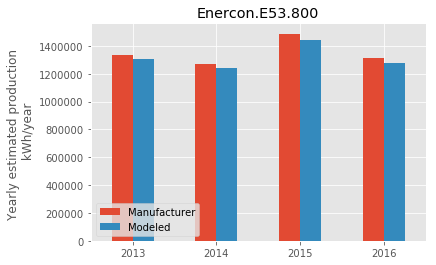

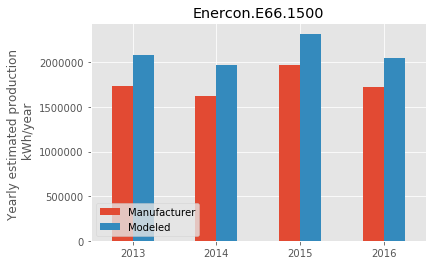

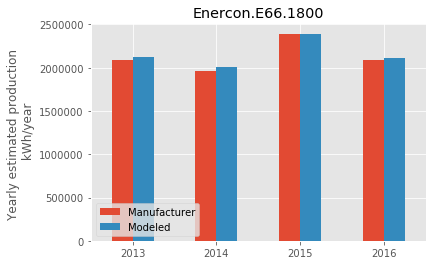

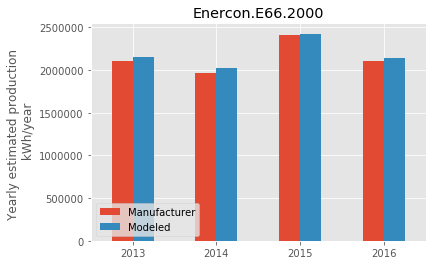

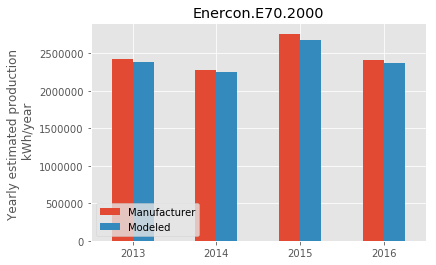

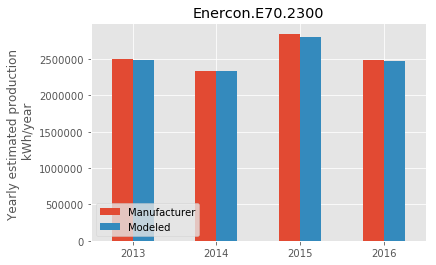

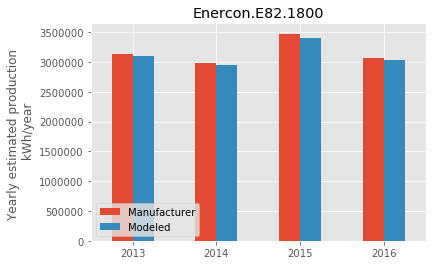

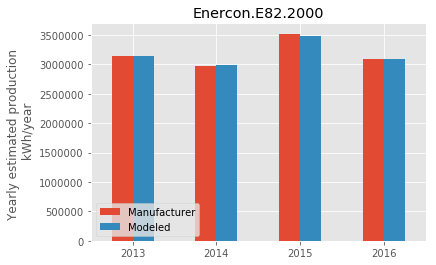

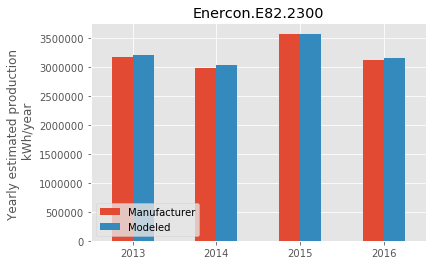

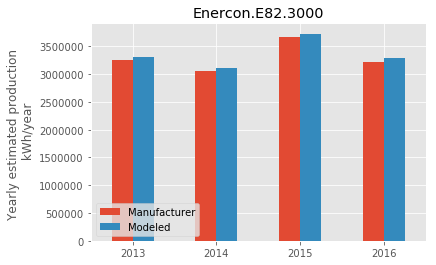

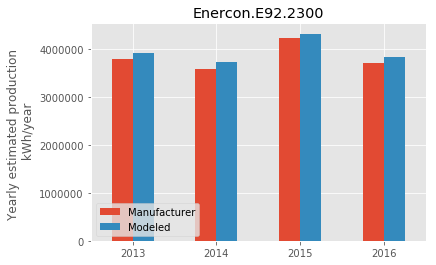

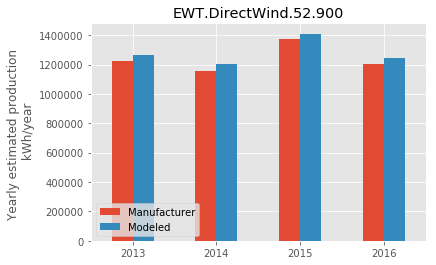

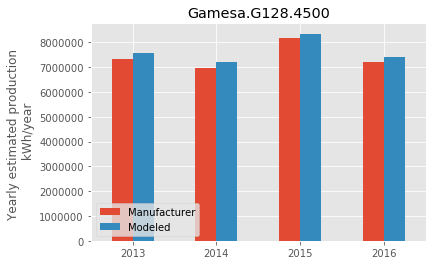

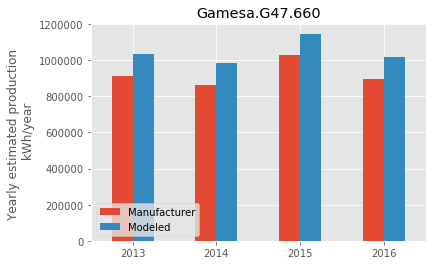

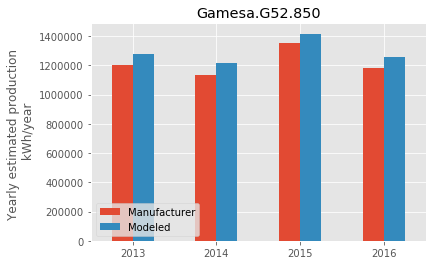

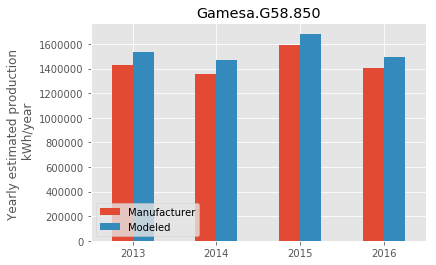

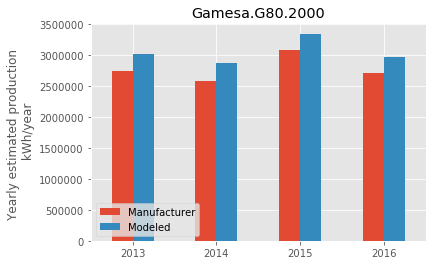

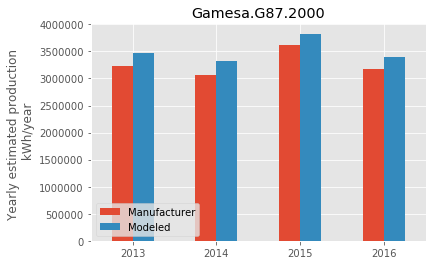

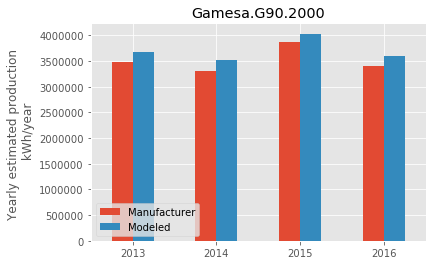

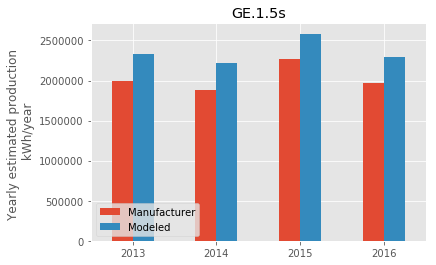

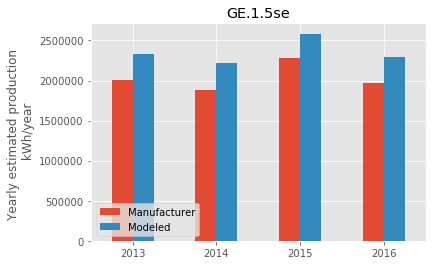

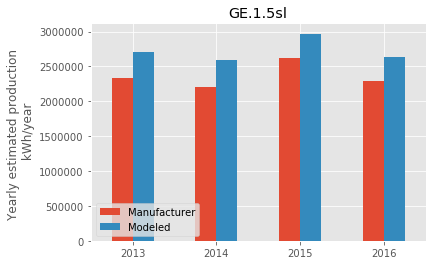

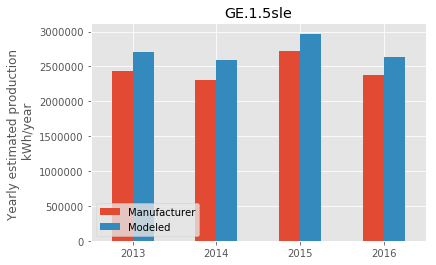

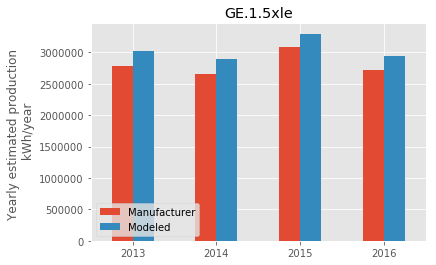

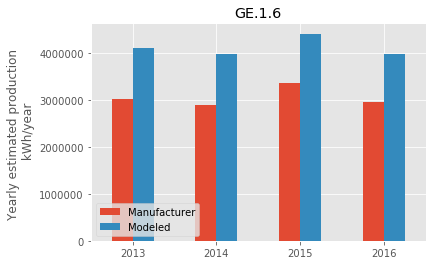

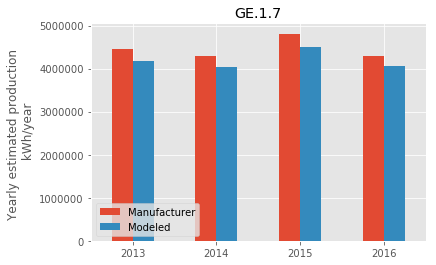

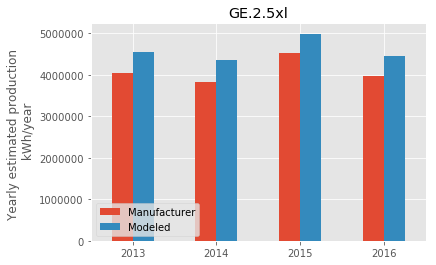

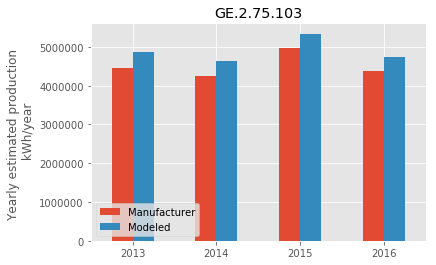

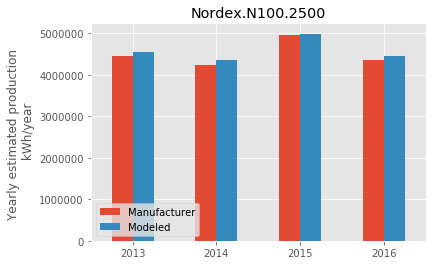

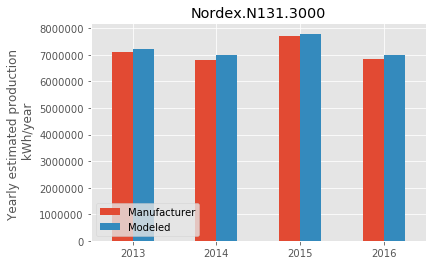

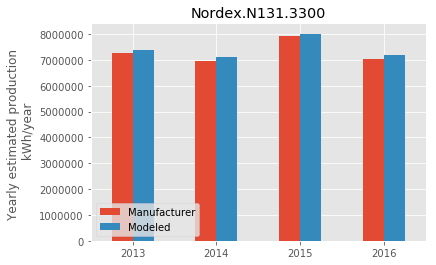

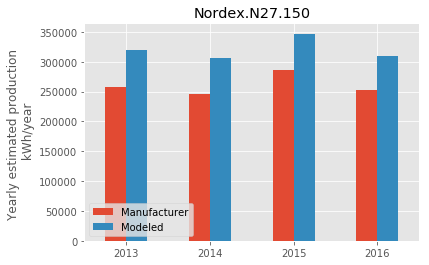

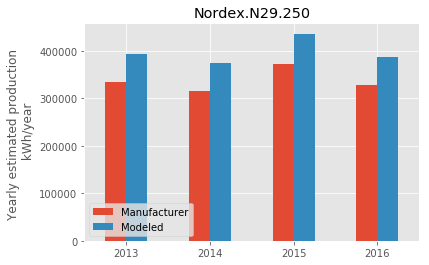

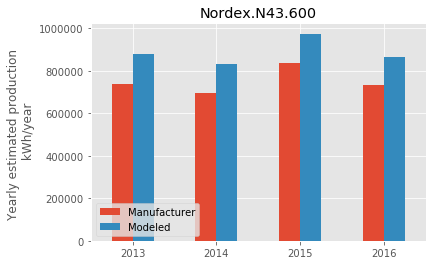

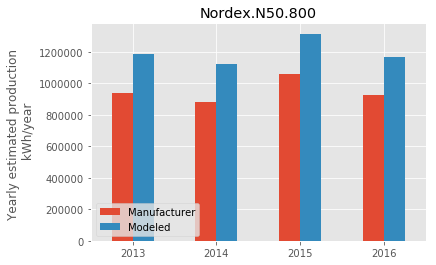

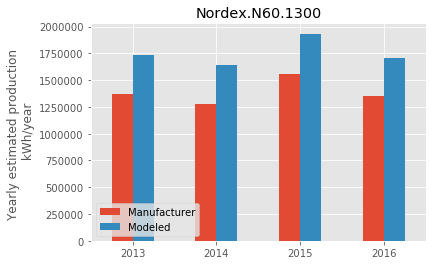

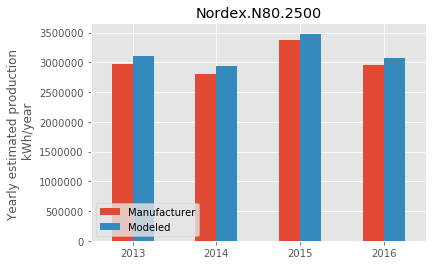

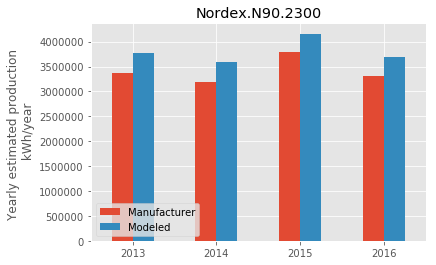

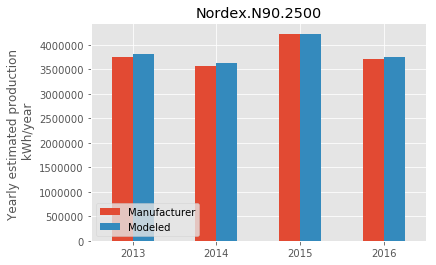

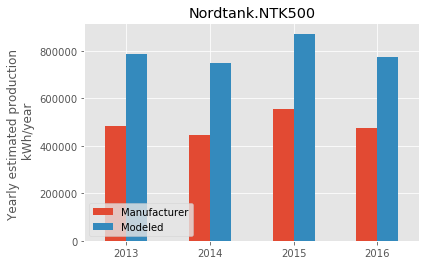

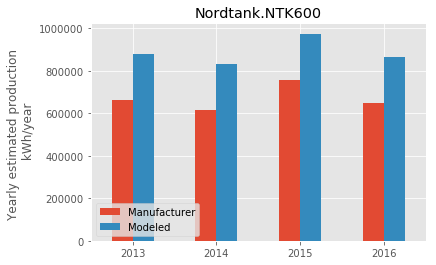

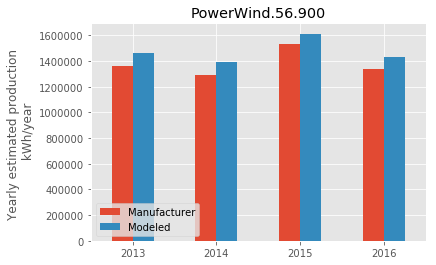

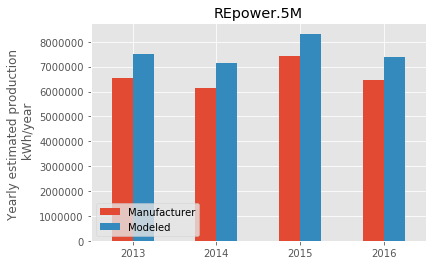

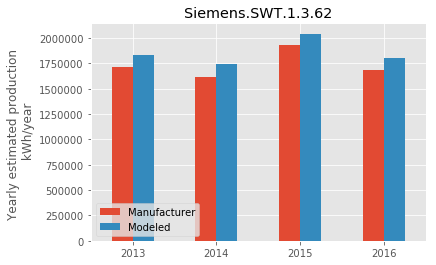

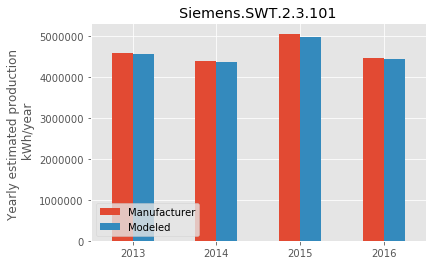

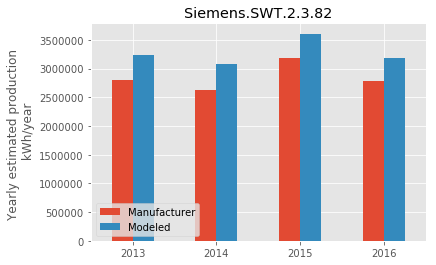

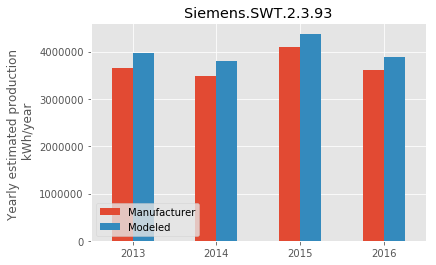

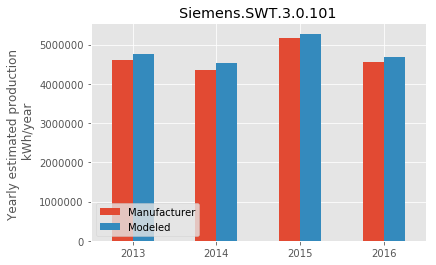

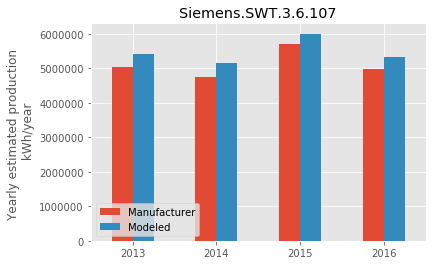

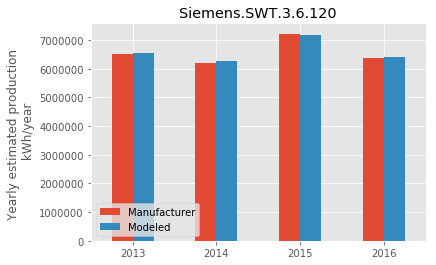

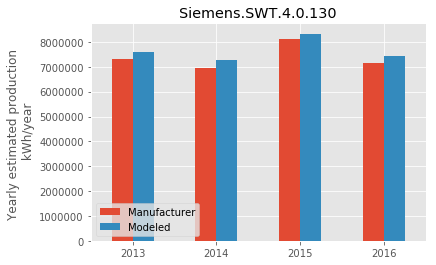

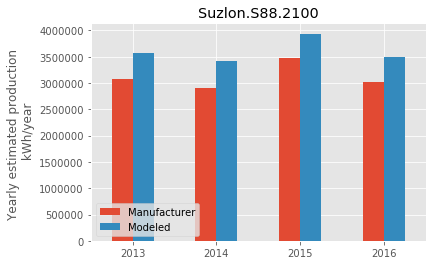

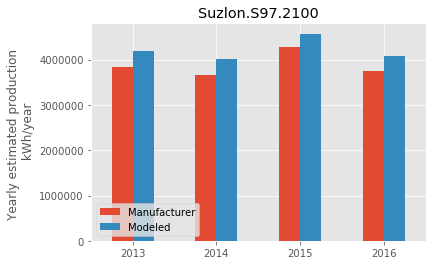

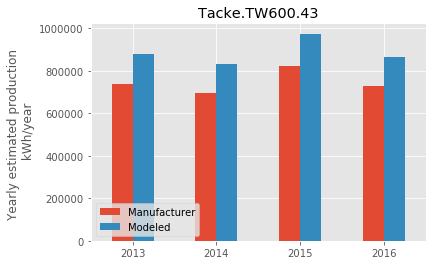

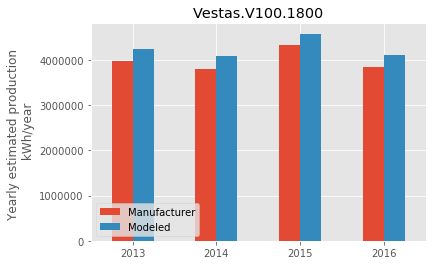

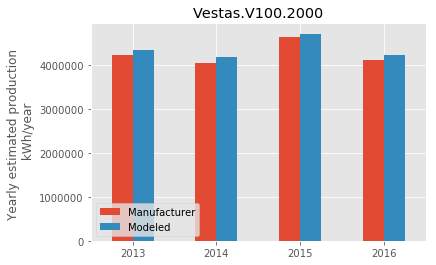

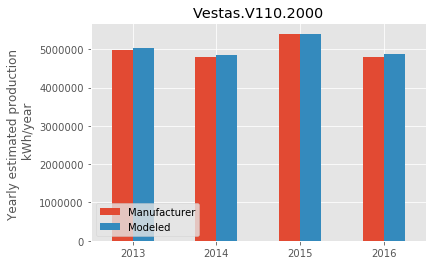

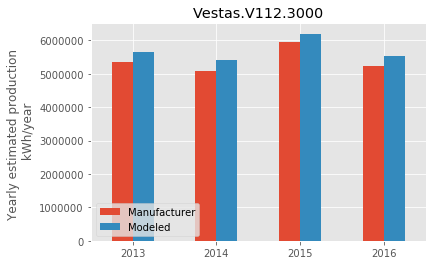

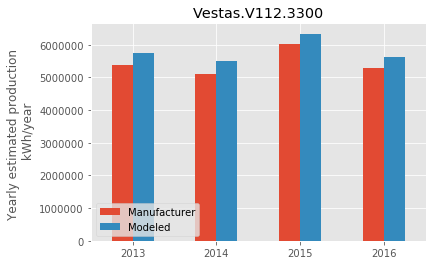

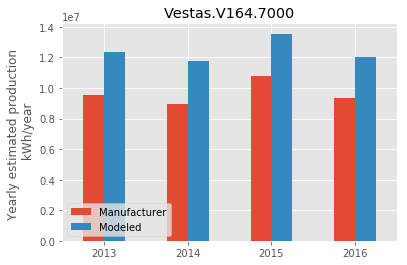

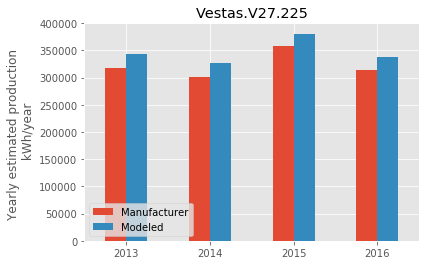

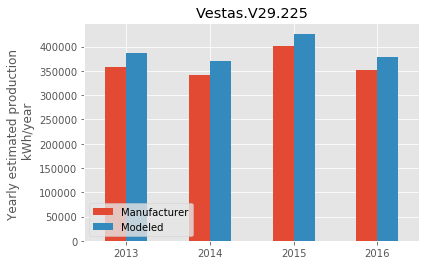

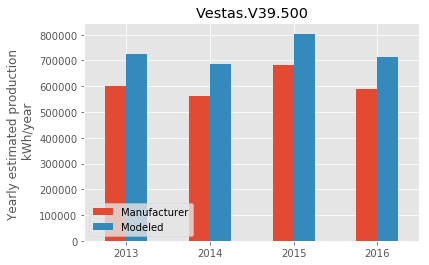

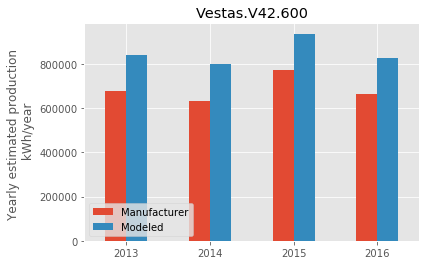

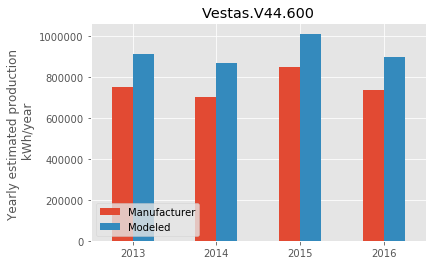

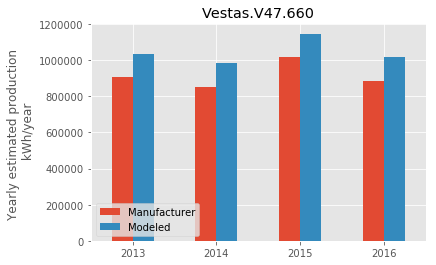

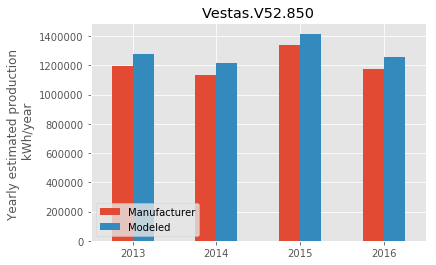

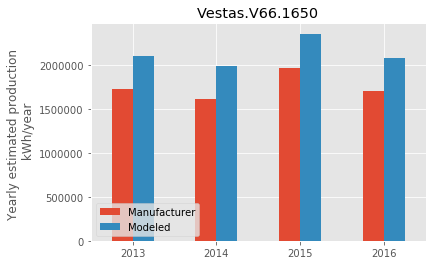

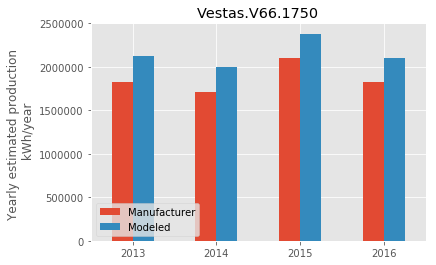

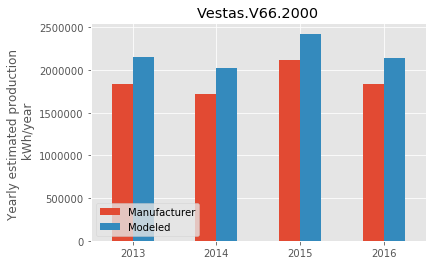

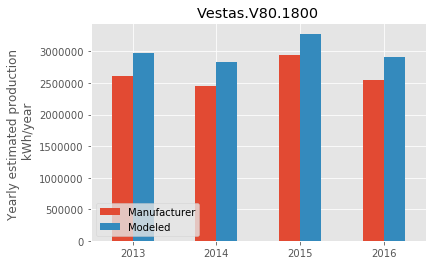

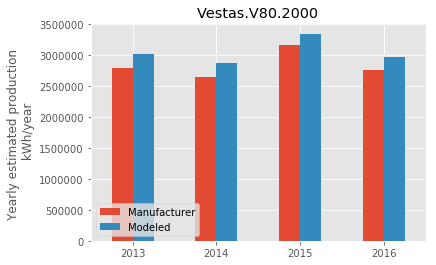

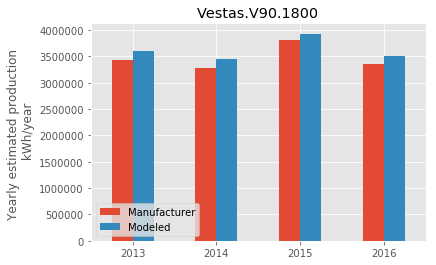

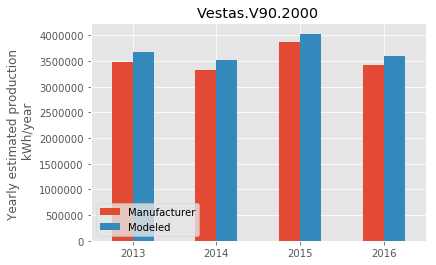

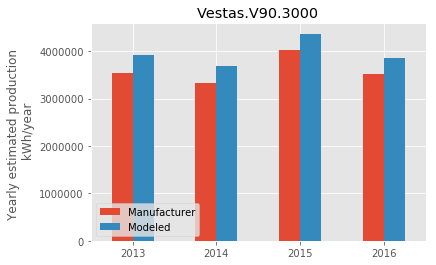

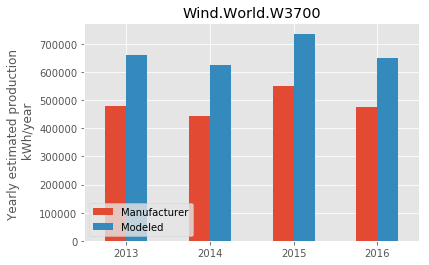

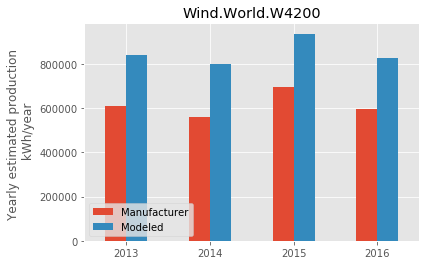

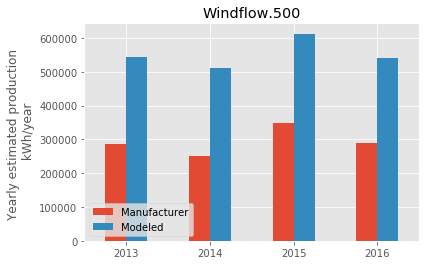

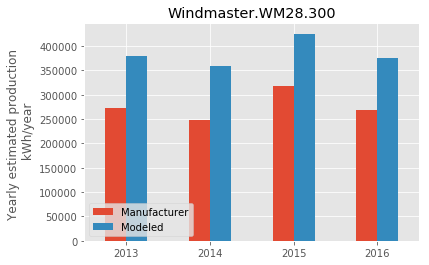

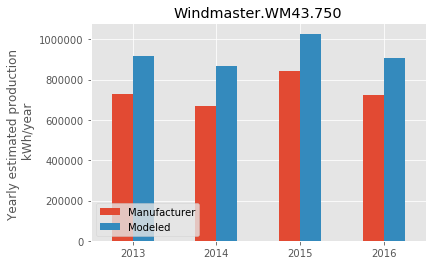

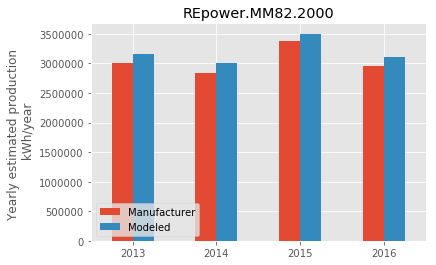

In [39]:
#Estimation of annual production
import matplotlib.dates as mdates

YP = df_P['2013':].swaplevel(axis = 1).resample('a').sum()
YP.index = [2013, 2014, 2015, 2016]

for turbine in YP.columns.levels[0][0:]:
    #print(turbine)
    fig, ax = plt.subplots(figsize = (6,4))
    YP[turbine].plot(kind = 'bar', ax = ax, rot = 0)
    plt.legend(loc = 3)
    plt.title('%s' %turbine)
    plt.ylabel('Yearly estimated production \n kWh/year')
  

Modeled / Manufacturer
count               99.000000
mean                 1.119544
std                  0.136490
min                  0.945025
25%                  1.033492
50%                  1.078600
75%                  1.161269
max                  1.871270

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000481267F978>]], dtype=object)

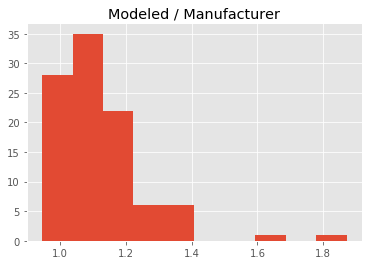

In [40]:
#Comparison of production from manufacturer and modeled power curve
YP = df_P['2016'].resample('a').sum()
A = (YP['Modeled']/YP['Manufacturer']).T
A.columns = ['Modeled / Manufacturer']
display(A.describe())
A.hist()

In [43]:
B = YP['Manufacturer'].T
B.columns = ['Manufacturer']
B['Modeled'] = YP['Modeled'].T
B['Modeled / Manufacturer'] = (B['Modeled']/B['Manufacturer'])
B = pd.concat([B, df_TDt], axis = 1)
B.head()

Manufacturer       Modeled  Modeled / Manufacturer   ID  \
Power curves name                                                            
Acciona.AW77.1500  2.373434e+06  2.641600e+06                1.112986  180   
Alstom.Eco.80      2.123924e+06  2.869363e+06                1.350973  322   
Alstom.Eco.110     5.030560e+06  5.353032e+06                1.064103  325   
Bonus.B23.150      2.087592e+05  2.410395e+05                1.154629  194   
Bonus.B33.300      4.851318e+05  5.031472e+05                1.037135  517   

                         Name Manufucturer ID  Manufucturer Licence  \
Power curves name                                                     
Acciona.AW77.1500  AW-1500/77              46       Acciona     NaN   
Alstom.Eco.80              80              35  Alstom Power     NaN   
Alstom.Eco.110            110              35  Alstom Power     NaN   
Bonus.B23.150         B23/150              39         Bonus     NaN   
Bonus.B33.300         B33/300              39         Bonus     NaN   

                   Wind class Wind class 2   ...    Generator manufacturer  \
Power curves name                            ...                             
Acciona.AW77.1500     IEC IIa          NaN   ...                       NaN   
Alstom.Eco.80         IEC IIa          NaN   ...                       NaN   
Alstom.Eco.110     IEC IIa/Is          NaN   ...                       NaN   
Bonus.B23.150             NaN          NaN   ...                       ABB   
Bonus.B33.300             NaN          NaN   ...                       ABB   

                  Power regulation Tower manufacturer      Available since  \
Power curves name                                                            
Acciona.AW77.1500            Pitch  Acciona Windpower  2006-03-01 00:00:00   
Alstom.Eco.80                Pitch                NaN                  NaT   
Alstom.Eco.110               Pitch                NaN                  NaT   
Bonus.B23.150                Stall                NaN                  NaT   
Bonus.B33.300                Stall                NaN                  NaT   

                          Status               Update  Power curves name  \
Power curves name                                                          
Acciona.AW77.1500      Available  2017-08-30 00:00:00  Acciona.AW77.1500   
Alstom.Eco.80      Not available  2016-12-27 00:00:00      Alstom.Eco.80   
Alstom.Eco.110         Available  2016-12-27 00:00:00     Alstom.Eco.110   
Bonus.B23.150      Not available  2016-12-27 00:00:00      Bonus.B23.150   
Bonus.B33.300      Not available  2016-12-27 00:00:00      Bonus.B33.300   

                      HPWS     slope   WS 0.7  
Power curves name                              
Acciona.AW77.1500  8.53575  0.187731  9.60111  
Alstom.Eco.80      9.17828  0.168079  10.3682  
Alstom.Eco.110     8.30459  0.181809  9.40465  
Bonus.B23.150      8.73878  0.167016  9.93628  
Bonus.B33.300      8.53578  0.133047   10.039  

[5 rows x 49 columns]

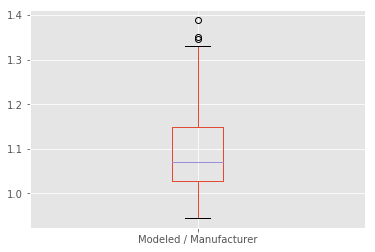

In [78]:
#Comparison without small wind turbine
B[B['Rated power'] > 500][['Modeled / Manufacturer']].boxplot()

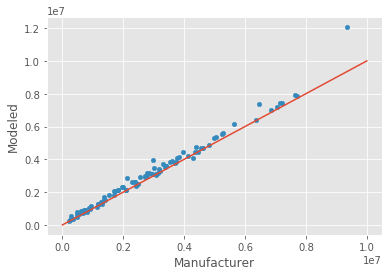

In [44]:
B.plot(kind = 'scatter', x = 'Manufacturer', y = 'Modeled' )
plt.plot([0, 1e7], [0, 1e7])

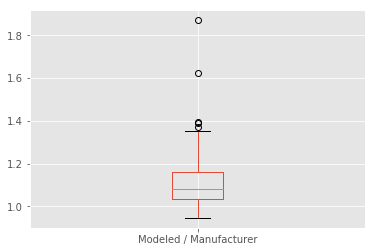

In [80]:
A.boxplot()

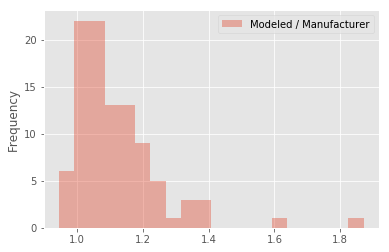

In [81]:
A.plot(kind = 'hist', alpha = 0.4, bins = 20)